<a href="https://colab.research.google.com/github/wwk45/bert/blob/main/BERT_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT - Bidirectional Encoder Representations from Transformers**


---



Language Models try to “fill in the blank” based on context

“The woman went to the store and bought a _____ of shoes.”

---

Before BERT, languange models would look at sequence unidirectionally

BERT is bi-directionally trained. BERT uses Masking, masks random words and tries to predict them. 

Takes into account both previous and next tokens

---

BERT is based on the Transformer model architecture

Transformer works by performing a small, constant number of steps. Each step applies attention mechanism to understand relationship between all words in a sentence

---

“I arrived at the bank after crossing the river” 


In [1]:
!pip install transformers
!pip install praw

from transformers import TFAutoModelForTokenClassification, AutoTokenizer 
from matplotlib import pyplot as plt 
import tensorflow as tf 
import praw 
from wordcloud import WordCloud


model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english") #Our BERT pre-trained model :)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

     |████████████████████████████████| 1.4MB 5.7MB/s 
     |████████████████████████████████| 890kB 37.1MB/s 
     |████████████████████████████████| 2.9MB 41.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=877fc5c69ca45ab0758b778f7cee3792e9ed552b7848d11ebafee5dab0c83dba
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 153kB 5.6MB/s 
     |████████████████████████████████| 204kB 7.8MB/s 


Some layers from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing TFBertForTokenClassification: ['dropout_147']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english and are newly initialized: ['dropout_73']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We obtain an instance of the reddit class by using the PRAW.
Reddit instance:
  i) read-only
  ii)authorized

In [2]:
categories = ["O", "B-MISC", "I-MISC", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]

reddit = praw.Reddit(client_id='Mm4cv9Uvh0QUEw', client_secret='deo-CJ9u_QY8VLWOVWtapjXiCYvVqw', user_agent='Wajahat Khan')

In [3]:
def comment_replies(top_comm, list_of_comments):
    if len(top_comm.replies) == 0:
        return
    else:
        for num, comment in enumerate(top_comm.replies):
            try:
                list_of_comments.append(str(comment.body))
            except:
                continue
            comment_replies(comment, list_of_comments) #recursive function

BERT model trained for 4 types of entities:
1. LOC
2. ORG
3. PER
4. MISC

In [4]:
list_of_subreddit = ['India','Politics']
count = 0
final_dict = {'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []} #BERT tags present in pre-trained model
temp_word = ''
current_tag = ''
old_tag = ''
print_dic = {}
list_of_comments = [] # Will use this to store our fetched data

In [5]:
for j in list_of_subreddit:
    # We getting the top posts for last month and limiting it to 1
    top_posts = reddit.subreddit(j).top('month', limit=1) 
    for submission in top_posts:
        print('\n')
        print("Title :" , submission.title)
        submission_instance = reddit.submission(id=submission.id)
        list_of_comments.append(str(submission.title))

        for count, top_comm in enumerate(submission_instance.comments):
            try:
                comment_replies(top_comm, list_of_comments) # top level comment is id of comment
            except:
                continue




Title : I know memes are not allowed here, but really wanted to get my message across


Title : Biden's Pennsylvania lead is now big enough to avoid an automatic recount


In [6]:
#print("\n\n\n Given below are the comments extracted\n")
#print(list_of_comments)



BERT uses BPE based Wordpiece Tokenisation, out of vocabulary word into subwords

Predicts if next sentence random or connected

---



Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.

Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.

Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

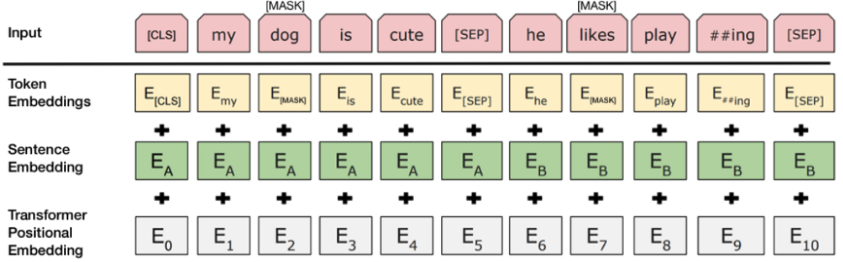

In [7]:
for sequence in list_of_comments:
    if len(sequence) > 512: # Comment more than 512, we skip, cuz BERT cannot work with that
        continue
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
    #print("\nThese are the tokens:")
    #print(tokens)
    inputs = tokenizer.encode(sequence, return_tensors="tf")
    #print("\nThese are the inputs:")
    #print(inputs)
    outputs = model(inputs)[0]
    #print("\nThese are the outputs:")
    #print(outputs)
    predictions = tf.argmax(outputs, axis=2)
    sequence_bert = [(token, categories[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]
    #print("\nThese is the sequence_bert:")
    #print(sequence_bert)
    for i in sequence_bert: 
        if i[1] in ['O', 'B-MISC', 'I-MISC']:
            if len(current_tag) > 0:
                word_remove_whitespace = temp_word.strip()
                if len(word_remove_whitespace) > 1:
                    final_dict[current_tag].append(word_remove_whitespace)
            temp_word = ''
            current_tag = ''
            continue
        else:
            current_tag = i[1]

            if old_tag != current_tag and len(old_tag) > 0:
                word_remove_whitespace = temp_word.strip()
                if len(word_remove_whitespace) > 1:
                    final_dict[old_tag].append(word_remove_whitespace)
                temp_word = ''
                current_tag = ''

            if i[0].startswith('##'): 
                temp_word += i[0][2:].upper()
            elif i[1] in ['I-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG', 'B-PER']:
                temp_word += " " + i[0].upper()
                current_tag = i[1]
            old_tag = current_tag

In [8]:
#print("Given below are all of the keywords we found along with their duplicates\n\n")
#print(final_dict)
#print_dic['Location'] = list(set(final_dict['I-LOC'] + final_dict['B-LOC']))
#print_dic['Organisation'] = list(set(final_dict['I-ORG'] + final_dict['B-ORG']))
#print_dic['Person Name'] = list(set(final_dict['I-PER'] + final_dict['B-PER']))
#print("\n\n\n\nNow we printing all keywords by deleting duplicates and we categorize them based on Location, Organisation and Person Name\n")
#print("Location:")
#print(print_dic['Location'])
#print("\nOrganisation:")
#print(print_dic['Organisation'])
#print("\nPerson Name:")
#print(print_dic['Person Name'])

In [9]:
keywords = list(final_dict['I-LOC'] + final_dict['B-LOC'] + final_dict['I-ORG'] + final_dict['B-ORG'] + final_dict['I-PER'] + final_dict['B-PER'])
result_dict = {}

for keyword in keywords:
  if keyword not in result_dict:
    result_dict[keyword] = 1
  else:
    result_dict[keyword] += 1

#result_dict = sorted(result_dict.items(), key = lambda x: x[1], reverse=True)

print("These are all the key words along with the occurences of each keyword")
print(result_dict)


These are all the key words along with the occurences of each keyword
{'INDIA': 14, 'BOLLYWOOD': 8, 'AUSTRALIA': 4, 'SINGAPORE': 1, 'MUMBAI': 1, 'TAMIL NADU': 1, 'MIRZAPUR': 1, '[CLS]': 1, 'JAPAN': 1, 'CHINA': 1, 'WALL STREET': 1, 'VILLAGE': 1, 'BIHAR': 1, 'HOLLYWOOD': 2, 'PENNSYLVANIA': 2, 'CHESTER COUNTY': 2, 'CHESTER': 2, 'PHOENIXVILLE': 1, 'TN': 1, 'MONTGOMERY': 1, 'PA': 8, 'WEST VIRGINIA': 1, 'OHIO': 2, 'LOUISIANA': 1, 'TEXAS': 2, 'USA': 1, 'AMERICA': 3, 'GEORGIA': 9, 'WISCONSIN': 2, 'MEXICO': 1, 'UK': 2, 'US': 2, 'LAFAYETTE SQUARE': 1, 'SUPREME COURTYARD': 3, 'NY': 1, 'EDMONTON': 1, 'ONTARIO': 1, 'CANADA': 1, 'GA': 5, 'CALIFORNIA': 5, 'NEW YORK': 1, 'FLORIDA': 2, 'PORTLAND': 1, 'PHOENIX': 1, 'ALBUQUERQUE': 1, 'AUSTIN': 1, 'WYOMING': 1, 'NJ': 1, 'NEW JERSEY': 1, 'SC': 1, 'HARRISBURG': 1, 'ARIZONA': 1, 'MADISON SQUARE GARDEN': 1, 'BROAD AND FAIRMOUNT': 1, 'FOUR SEASONS': 1, 'WHITE HOUSE': 1, 'PHILLY': 1, 'GVM': 1, 'DDLJ': 1, 'MARK CHANNEL': 1, 'MARK': 1, 'TWILIGHT': 1, 'AIB': 2, 'S

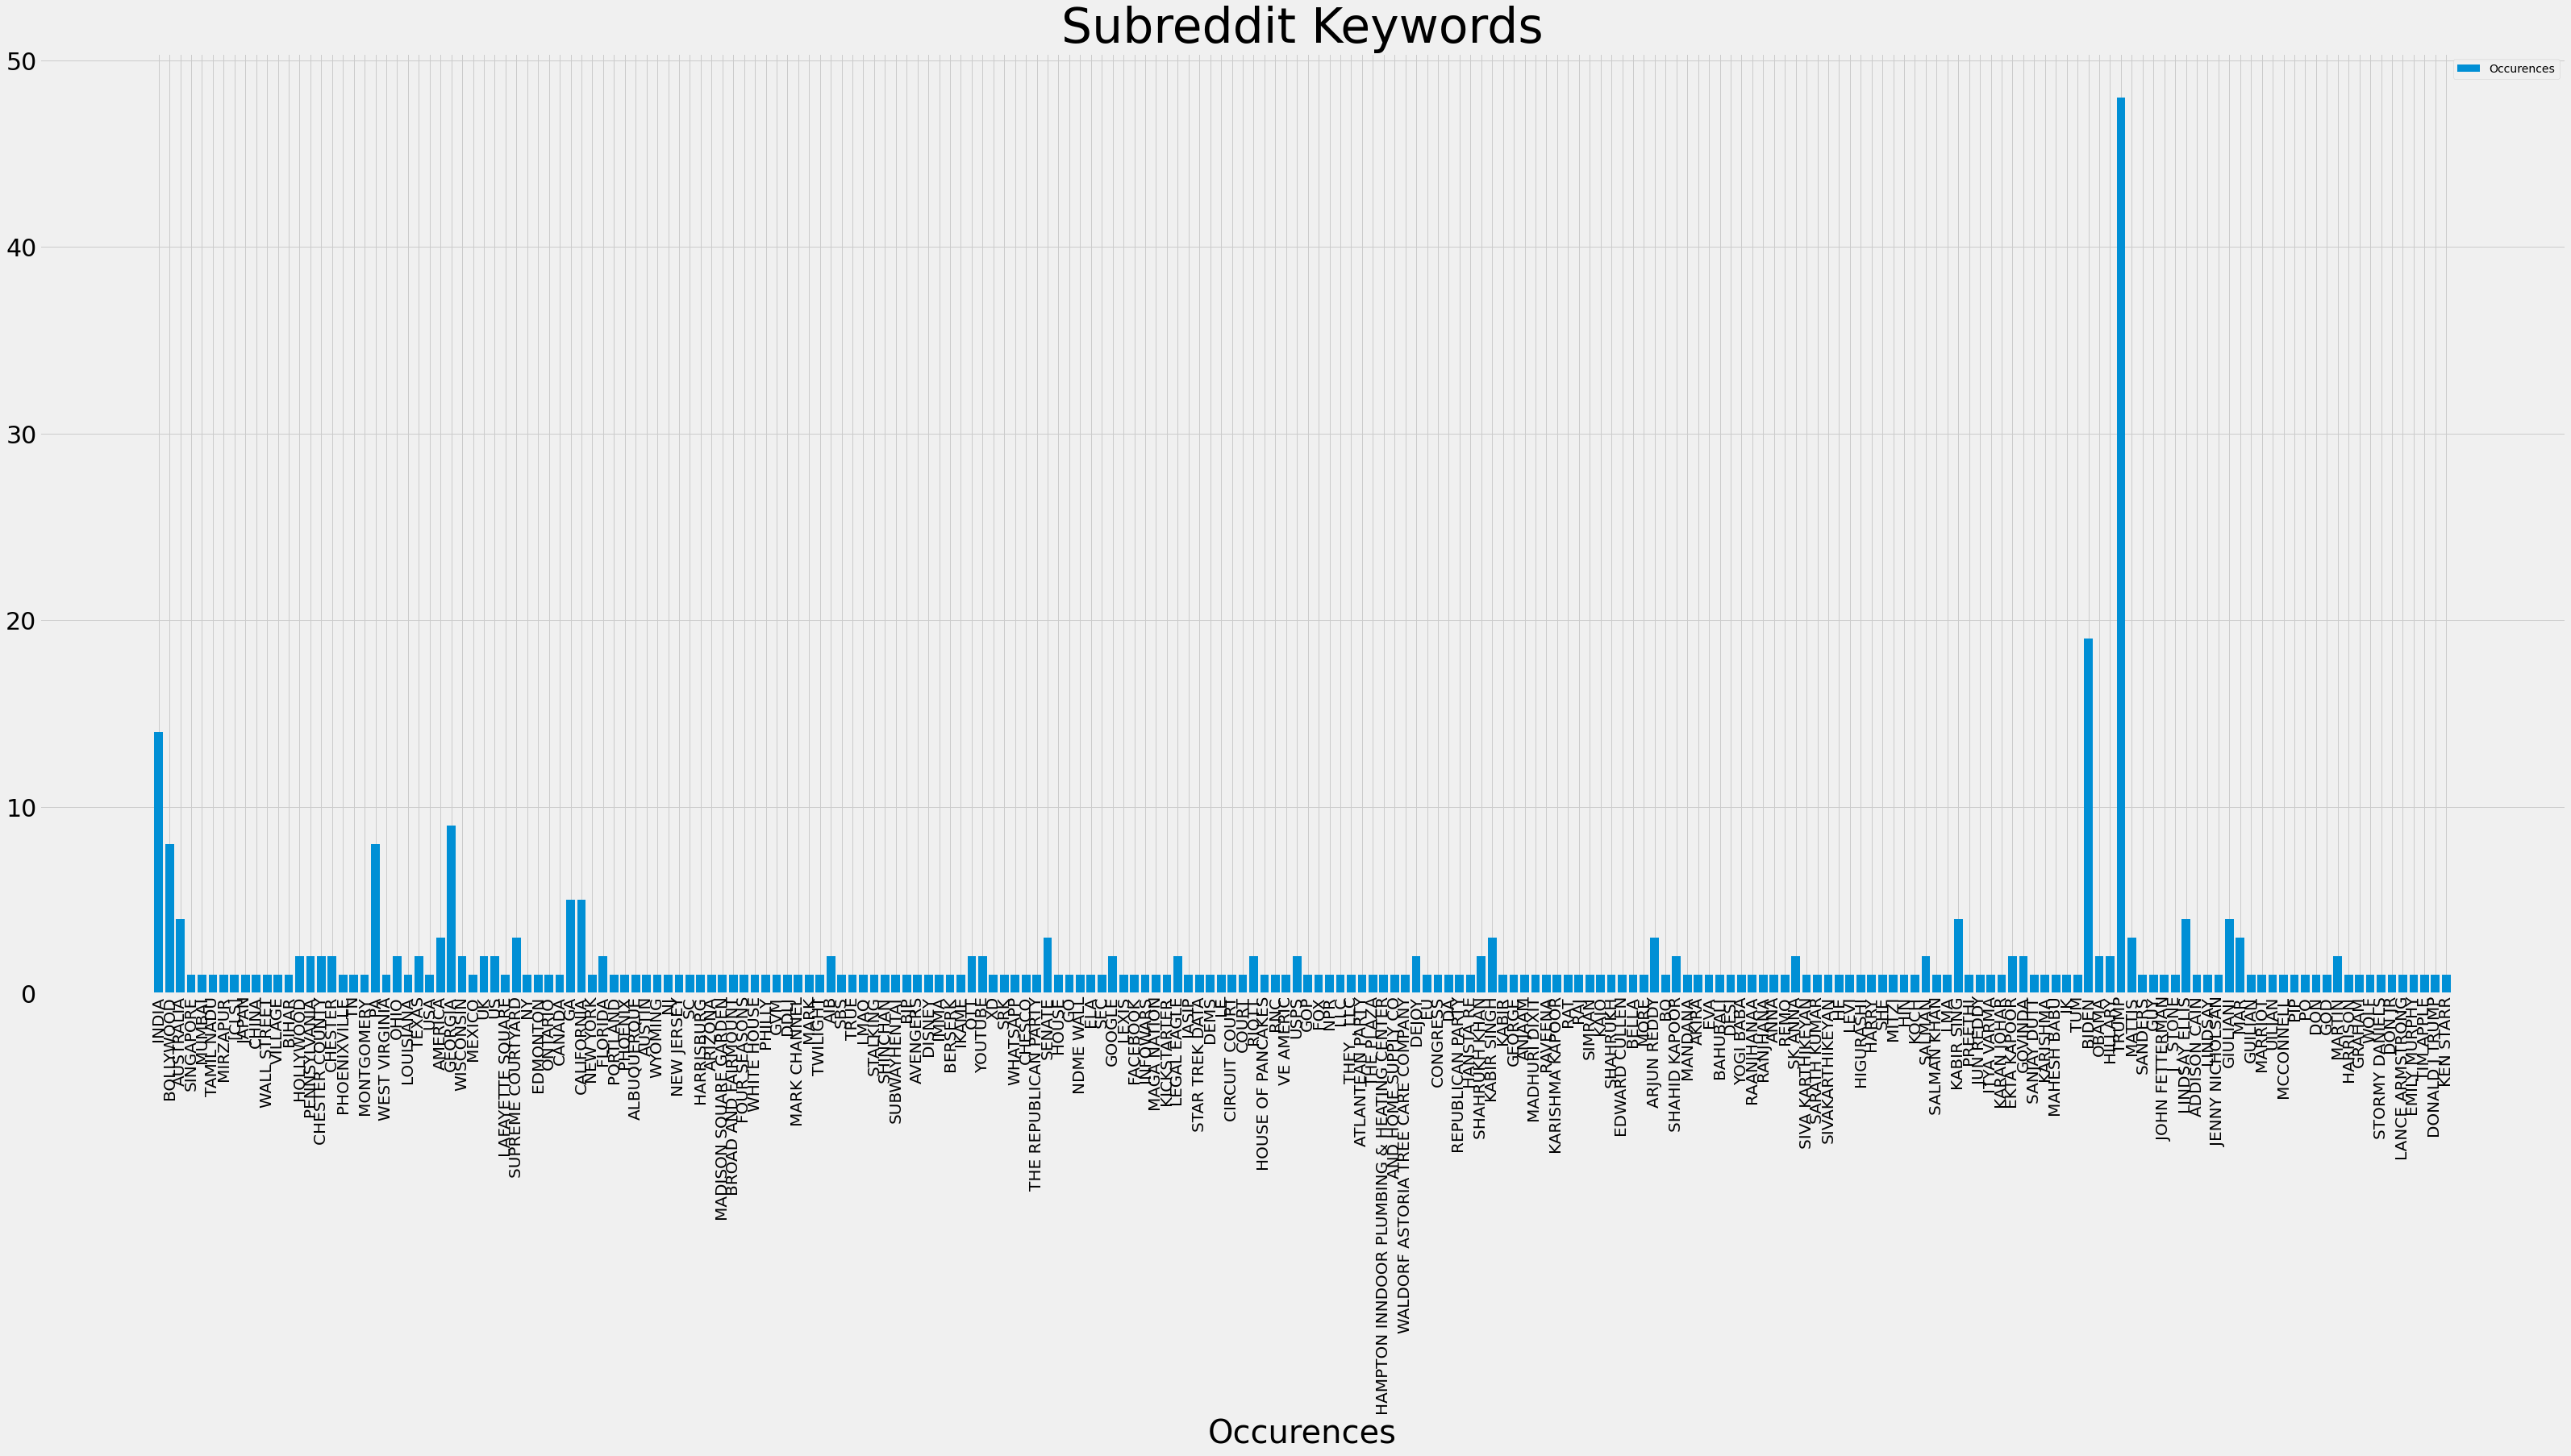

In [10]:
width = 50
height = 20

x_axis = range(len(result_dict))

plt.style.use('fivethirtyeight') 

plt.figure(figsize=(width, height))
plt.bar(x_axis, list(result_dict.values()), label="Occurences")

plt.xticks(x_axis, list(result_dict.keys()), rotation=90, fontsize=20)
plt.yticks(fontsize = 30)

plt.title("Subreddit Keywords", fontsize=60)
plt.xlabel("Keywords", fontsize=40)
plt.xlabel("Occurences", fontsize=40)

plt.legend()

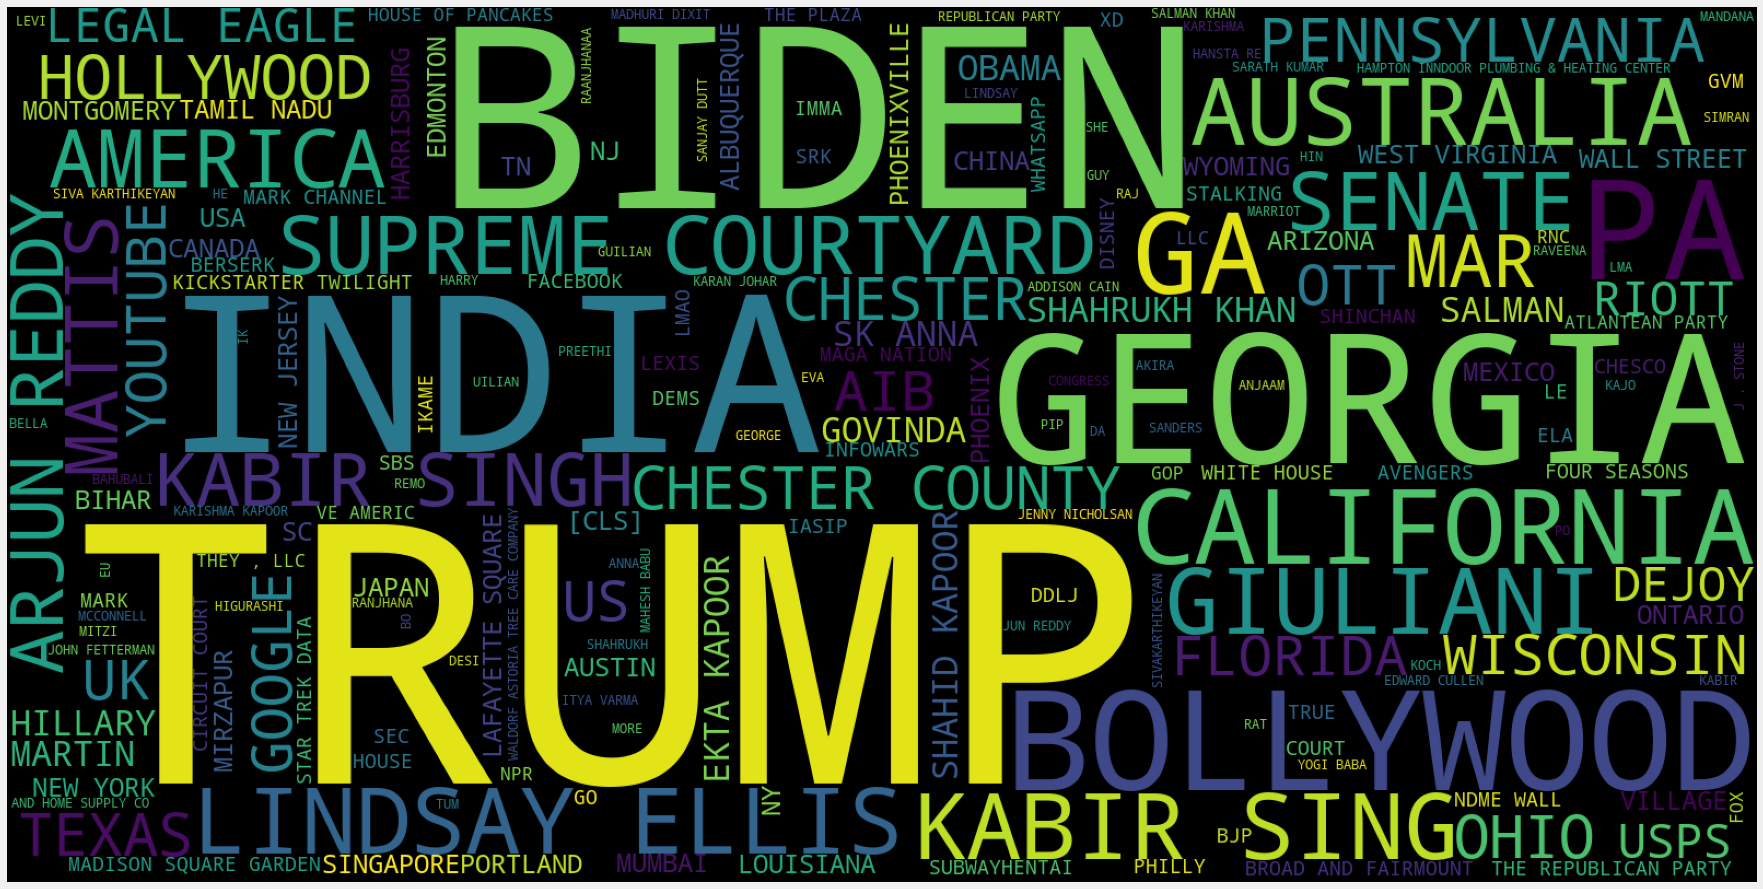

In [11]:
#yesh = WordCloud(width=800, height=400).generate(result_dict.key())
yesh = WordCloud(width=1600, height=800)
yesh.generate_from_frequencies(result_dict)
plt.figure( figsize=(30,15) )
plt.imshow(yesh)
plt.axis("off")
plt.show()